# Analyze of Storm data

In this report we're going to take a look at the storms recorded in the US.

for this report we're going to use the data from the  U.S. National Oceanic and Atmospheric Administration's ([NOAA](https://www.noaa.gov/)) storm database. This database tracks characteristics of major storms and weather events in the United States, including when and where they occur, as well as estimates of any fatalities, injuries, and property damage.

We're going to investigate different types of storms and find the ones that cause the most damage with respect to the population and economy.


### Data Processing
First let's load the data and look at its first rows.

In [1]:
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.7     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
zip_file = "../input/repdata_data_StormData.csv.bz2"

if (!file.exists(zip_file)) {
    download.file(
        url = "https://d396qusza40orc.cloudfront.net/repdata%2Fdata%2FStormData.csv.bz2",
        destfile = zip_file
    )
}

In [3]:
stormData <- read_csv("../input/repdata_data_StormData.csv.bz2")
raw_data <- stormData
head(stormData)

Rows: 902297 Columns: 37
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (18): BGN_DATE, BGN_TIME, TIME_ZONE, COUNTYNAME, STATE, EVTYPE, BGN_AZI,...
dbl (18): STATE__, COUNTY, BGN_RANGE, COUNTY_END, END_RANGE, LENGTH, WIDTH, ...
lgl  (1): COUNTYENDN

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


STATE__,BGN_DATE,BGN_TIME,TIME_ZONE,COUNTY,COUNTYNAME,STATE,EVTYPE,BGN_RANGE,BGN_AZI,⋯,CROPDMGEXP,WFO,STATEOFFIC,ZONENAMES,LATITUDE,LONGITUDE,LATITUDE_E,LONGITUDE_,REMARKS,REFNUM
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,4/18/1950 0:00:00,0130,CST,97,MOBILE,AL,TORNADO,0,NA,⋯,NA,NA,NA,NA,3040,8812,3051,8806,NA,1
1,4/18/1950 0:00:00,0145,CST,3,BALDWIN,AL,TORNADO,0,NA,⋯,NA,NA,NA,NA,3042,8755,0,0,NA,2
1,2/20/1951 0:00:00,1600,CST,57,FAYETTE,AL,TORNADO,0,NA,⋯,NA,NA,NA,NA,3340,8742,0,0,NA,3
1,6/8/1951 0:00:00,0900,CST,89,MADISON,AL,TORNADO,0,NA,⋯,NA,NA,NA,NA,3458,8626,0,0,NA,4
1,11/15/1951 0:00:00,1500,CST,43,CULLMAN,AL,TORNADO,0,NA,⋯,NA,NA,NA,NA,3412,8642,0,0,NA,5
1,11/15/1951 0:00:00,2000,CST,77,LAUDERDALE,AL,TORNADO,0,NA,⋯,NA,NA,NA,NA,3450,8748,0,0,NA,6


Lets clean our data a bit and select the columns that we're going to need for this report.

The columns "FATALITIES" and "INJURIES" are the one that report the damage to the population. 

And the columns "PROPDMG","PROPDMGEXP", "CROPDMG", "CROPDMGEXP" are the damage to the economy.

In [5]:
stormData <- stormData %>%
    select(STATE, COUNTYNAME, BGN_DATE, , EVTYPE, F, FATALITIES:INJURIES, PROPDMG:CROPDMGEXP)

# Convert the date to a date format
if (!inherits(stormData$BGN_DATE, "Date")) {
    stormData <- stormData %>%
        mutate(across(BGN_DATE, gsub, pattern = " .*", replacement = "")) %>%
        mutate(BGN_DATE = as.Date(BGN_DATE, format = "%m/%d/%Y"))
}

# Create factors
stormData <- stormData %>%
    mutate(
        STATE = as.factor(STATE),
        F = as.factor(F),
        EVTYPE = as.factor(EVTYPE),
    )

In [8]:
summary(stormData)
str(stormData)

     STATE         COUNTYNAME           BGN_DATE         
 TX     : 83728   Length:902297      Min.   :1950-01-03  
 KS     : 53440   Class :character   1st Qu.:1995-04-20  
 OK     : 46802   Mode  :character   Median :2002-03-18  
 MO     : 35648                      Mean   :1998-12-27  
 IA     : 31069                      3rd Qu.:2007-07-28  
 NE     : 30271                      Max.   :2011-11-30  
 (Other):621339                                          
               EVTYPE          F            FATALITIES      
 HAIL             :288661   0   : 24993   Min.   :  0.0000  
 TSTM WIND        :219944   1   : 19475   1st Qu.:  0.0000  
 THUNDERSTORM WIND: 82563   2   :  9878   Median :  0.0000  
 TORNADO          : 60652   3   :  3179   Mean   :  0.0168  
 FLASH FLOOD      : 54278   4   :  1072   3rd Qu.:  0.0000  
 FLOOD            : 25326   5   :   137   Max.   :583.0000  
 (Other)          :170873   NA's:843563                     
    INJURIES            PROPDMG         PROPDMGE

tibble [902,297 x 11] (S3: tbl_df/tbl/data.frame)
 $ STATE     : Factor w/ 72 levels "AK","AL","AM",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ COUNTYNAME: chr [1:902297] "MOBILE" "BALDWIN" "FAYETTE" "MADISON" ...
 $ BGN_DATE  : Date[1:902297], format: "1950-04-18" "1950-04-18" ...
 $ EVTYPE    : Factor w/ 977 levels "?","ABNORMAL WARMTH",..: 818 818 818 818 818 818 818 818 818 818 ...
 $ F         : Factor w/ 6 levels "0","1","2","3",..: 4 3 3 3 3 3 3 2 4 4 ...
 $ FATALITIES: num [1:902297] 0 0 0 0 0 0 0 0 1 0 ...
 $ INJURIES  : num [1:902297] 15 0 2 2 2 6 1 0 14 0 ...
 $ PROPDMG   : num [1:902297] 25 2.5 25 2.5 2.5 2.5 2.5 2.5 25 25 ...
 $ PROPDMGEXP: chr [1:902297] "K" "K" "K" "K" ...
 $ CROPDMG   : num [1:902297] 0 0 0 0 0 0 0 0 0 0 ...
 $ CROPDMGEXP: chr [1:902297] NA NA NA NA ...


Now I'll see how the total number of records have changed over the years.

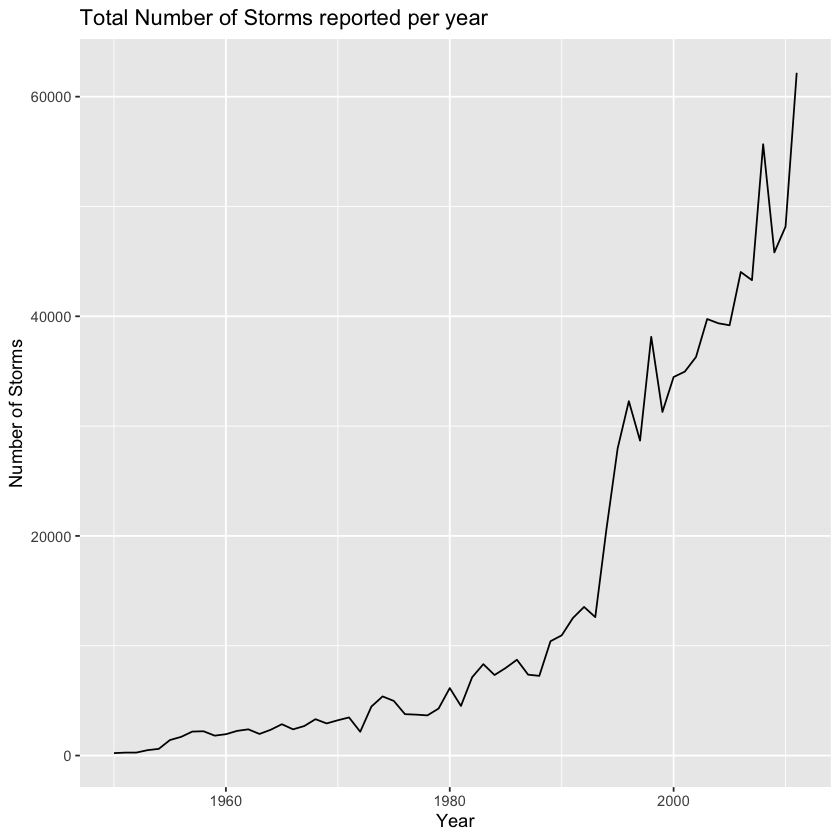

In [10]:
stormData %>%
    mutate(year = format(BGN_DATE, "%Y")) %>%
    group_by(year) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = as.numeric(year), y = n)) +
    geom_line() +
    labs(
        x = "Year", y = "Number of Storms",
        title = "Total Number of Storms reported per year"
    )

We can see there is an increase in the number of storms reported in the each year. 
Which is probably because of the lack of good records imn the earlier years.
The k,M in the columsn PROPDMGEXP, CROPDMGEXP stand for thousands, millions. We'll convert them to numbers.

And also there are some undfeined values like "?" or NA in the damage related columns. I'll replace them them with 0.

In [11]:
stormData <- stormData %>%
    mutate(across(c(PROPDMGEXP, CROPDMGEXP), gsub, pattern = "B|b", replacement = "9")) %>%
    mutate(across(c(PROPDMGEXP, CROPDMGEXP), gsub, pattern = "M|m", replacement = "6")) %>%
    mutate(across(c(PROPDMGEXP, CROPDMGEXP), gsub, pattern = "K|k", replacement = "3")) %>%
    mutate(across(c(PROPDMGEXP, CROPDMGEXP), gsub, pattern = "H|h", replacement = "2")) %>%
    mutate(across(c(PROPDMGEXP, CROPDMGEXP), gsub, pattern = "-|\\?|\\+", replacement = "0")) %>%
    mutate(PROPDMGEXP = as.numeric(PROPDMGEXP)) %>%
    mutate(CROPDMGEXP = as.numeric(CROPDMGEXP)) %>%
    mutate(PROPDMGEXP = replace_na(PROPDMGEXP, 0)) %>%
    mutate(CROPDMGEXP = replace_na(CROPDMGEXP, 0))

### Economic Damage

To find the most damaging event type we sum the damages to the propertyand crops to each other.
To do so we'll have to rescale them with the PROPDMGEXP which is the scaling factor.

In [12]:
stormData <- stormData %>%
    mutate(
        PROPDAMAGE = PROPDMG * 10**(PROPDMGEXP),
        CROPDAMAGE = CROPDMG * 10**(CROPDMGEXP),
        ECONOMICDAMAGE = PROPDAMAGE + CROPDAMAGE
    )
summary(stormData$ECONOMICDAMAGE)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.00e+00 0.00e+00 0.00e+00 5.29e+05 1.00e+03 1.15e+11 

We can see that 75% of the storms have an economic damage, less than thousands of dollars.

In this report I'll consider the storms that have the most total economic damge the worst ones.
So we sum the damages done by an event type and make a plt of the first ten to see which one does
the most damage. And we report the total damage in million dollars.

In [14]:
worstEconomic <- stormData %>%
    group_by(EVTYPE) %>%
    summarise(
        TOTALPROPDAMAGE = sum(PROPDAMAGE) / 1e6,
        TOTALCROPDAMAGE = sum(CROPDAMAGE) / 1e6,
    ) %>%
    arrange(desc(TOTALPROPDAMAGE + TOTALCROPDAMAGE)) %>%
    head(10) %>%
    mutate(EVTYPE = factor(EVTYPE, levels = EVTYPE))

The above section groups the same events together and calculates thier total damage.
and now for the plot we'll proceed this way.

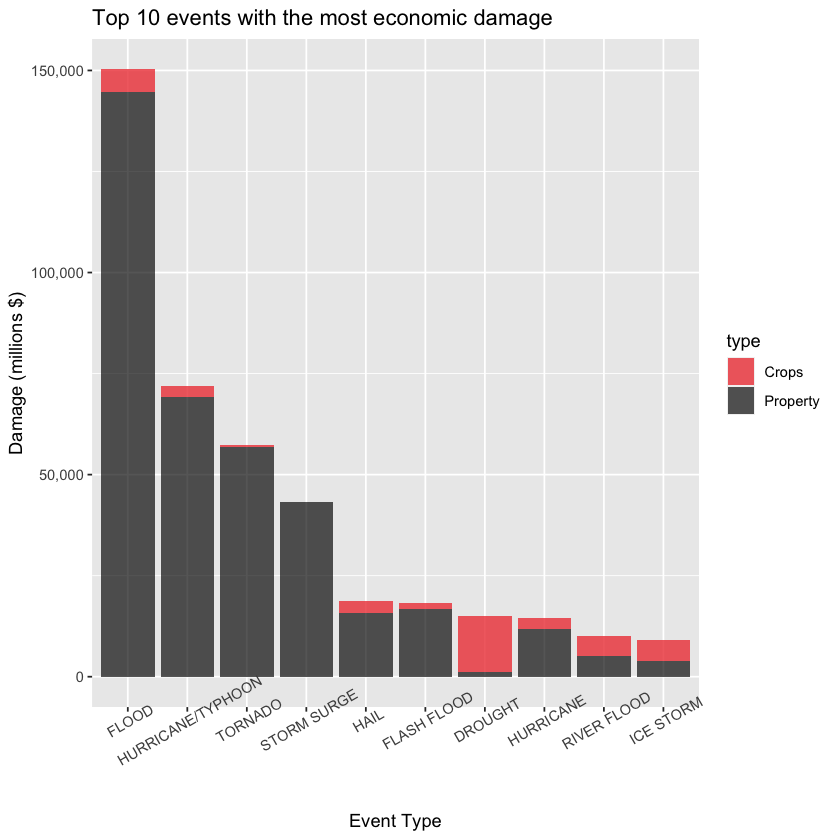

In [15]:
worstEconomic %>%
    pivot_longer(
        cols = c(TOTALPROPDAMAGE, TOTALCROPDAMAGE),
        names_to = "type", values_to = "Damage"
    ) %>%
    ggplot(
        aes(x = EVTYPE, y = Damage, fill = type)
    ) +
    geom_bar(
        position = "stack", stat = "identity"
    ) +
    scale_fill_manual(
        values = c("#ee4444cc", "#000000aa"),
        labels = c("Crops", "Property"),
    ) +
    labs(
        x = "Event Type", y = "Damage (millions $)",
        title = "Top 10 events with the most economic damage"
    ) +
    scale_y_continuous(labels = scales::comma) +
    theme(axis.text.x = element_text(angle = 30))

We can see that the event which causees the most damage to the economy is 
`r worstEconomic$EVTYPE[1]` with total damage of 
`r worstEconomic[1,]$TOTALPROPDAMAGE + worstEconomic[1,]$TOTALCROPDAMAGE` us$. 
So it makes sense to invest more to control that.
Also the plot makes it clear that the most economic damage is because of the damage done to the property with the only exception 
`r worstEconomic %>% filter(TOTALCROPDAMAGE > TOTALPROPDAMAGE) %>% select(EVTYPE) %>% head(1)`.

### Population Damage

As for the damage to the population.

In [16]:
worstPopulatoinStorms <- stormData %>%
    group_by(EVTYPE) %>%
    summarise(
        TOTALINJURIES = sum(INJURIES),
        TOTALFATALITIES = sum(FATALITIES),
        MEANINJURY = mean(INJURIES),
        MEANFATALITY = mean(FATALITIES)
    )

worstFatalities <- worstPopulatoinStorms %>%
    arrange(desc(TOTALFATALITIES)) %>%
    select(EVTYPE) %>%
    head(10)

worstInjuries <- worstPopulatoinStorms %>%
    arrange(desc(TOTALINJURIES)) %>%
    select(EVTYPE) %>%
    head(10)

worst <- worstPopulatoinStorms %>%
    filter(EVTYPE %in% worstFatalities$EVTYPE |
        EVTYPE %in% worstInjuries$EVTYPE) %>%
    arrange(desc(TOTALINJURIES + TOTALFATALITIES)) %>%
    mutate(EVTYPE = factor(EVTYPE, levels = EVTYPE))

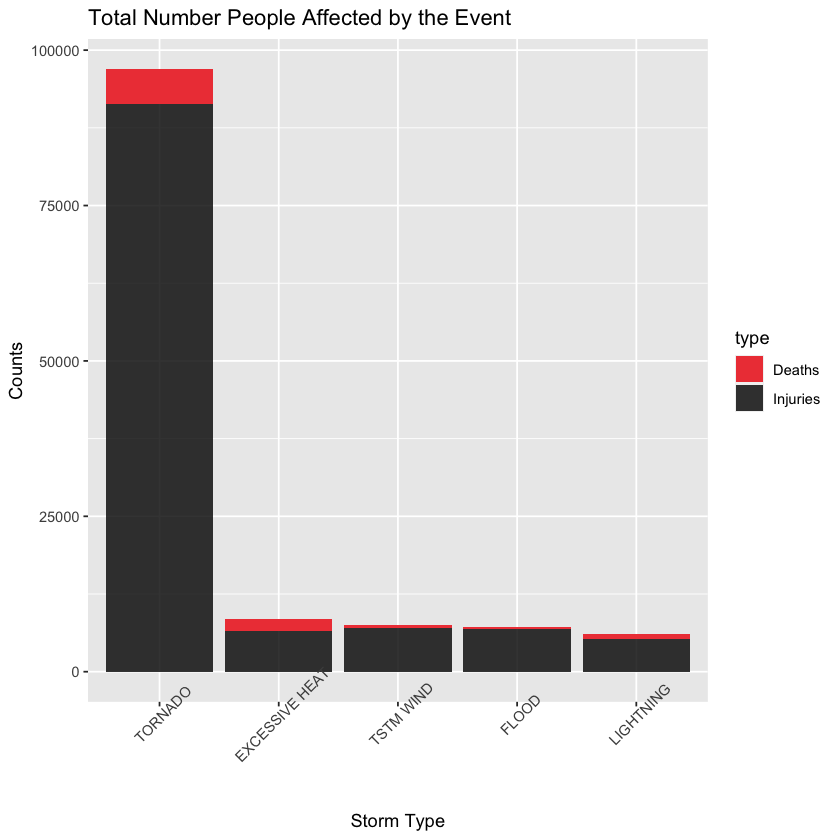

In [17]:
worst[1:5, ] %>%
    pivot_longer(
        cols = c(TOTALFATALITIES, TOTALINJURIES),
        names_to = "type", values_to = "count"
    ) %>%
    ggplot(aes(x = EVTYPE, y = count, fill = type)) +
    geom_bar(position = "stack", stat = "identity", ) +
    scale_fill_manual(
        values = c("#ee4444", "#000000cc"),
        labels = c("Deaths", "Injuries")
    ) +
    theme(axis.text.x = element_text(angle = 45)) +
    labs(
        x = "Storm Type", y = "Counts",
        title = "Total Number People Affected by the Event"
    )

It is clear that the most of the injuries and fatalities happen by far with
`r worst[1,]$EVTYPE`.